In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#Load data
air_data = pd.read_csv("data/air_quality_data.csv")
air_data.head()

,Station,Air Quality,Longitude,Latitude,O3 Hour,O3 Quality,O3 Value,NO2 Hour,NO2 Quality,NO2 Value,PM10 Hour,PM10 Quality,PM10 Value,Generated,Date Time
0,Barcelona - Sants,Good,2.1331,41.3788,NaN,NaN,NaN,0h,Good,84.0,NaN,NaN,NaN,01/11/2018 0:00,1541027104
1,Barcelona - Eixample,Moderate,2.1538,41.3853,0h,Good,1.0,0h,Moderate,113.0,0h,Good,36.0,01/11/2018 0:00,1541027104
2,Barcelona - Gràcia,Good,2.1534,41.3987,0h,Good,10.0,0h,Good,73.0,NaN,NaN,NaN,01/11/2018 0:00,1541027104
3,Barcelona - Ciutadella,Good,2.1874,41.3864,0h,Good,2.0,0h,Good,86.0,NaN,NaN,NaN,01/11/2018 0:00,1541027104
4,Barcelona - Vall Hebron,Good,2.1480,41.4261,0h,Good,7.0,0h,Good,69.0,NaN,NaN,NaN,01/11/2018 0:00,1541027104


In [3]:
#shape
air_data.shape

(5744, 15)

In [4]:
#dtypes
air_data.dtypes

Station          object
Air Quality      object
Longitude       float64
Latitude        float64
O3 Hour          object
O3 Quality       object
O3 Value        float64
NO2 Hour         object
NO2 Quality      object
NO2 Value       float64
PM10 Hour        object
PM10 Quality     object
PM10 Value      float64
Generated        object
Date Time         int64
dtype: object

**1. Exploratory Analysis**

In [5]:
#Statistics
air_data.describe()

,Longitude,Latitude,O3 Value,NO2 Value,PM10 Value,Date Time
count,5744.00000,5744.000000,4101.000000,5460.000000,3647.000000,5.744000e+03
mean,2.15240,13877.827714,34.082907,35.740293,16.590074,1.542323e+09
std,0.02859,74410.803168,22.960687,22.357262,8.065424,7.483961e+05
min,2.11510,41.378800,1.000000,1.000000,2.000000,1.541027e+09
25%,2.13080,41.386400,14.000000,17.000000,10.000000,1.541675e+09
50%,2.15070,41.398700,34.000000,33.000000,15.000000,1.542325e+09
75%,2.16220,41.418300,52.000000,52.000000,22.000000,1.542971e+09
max,2.20450,414261.000000,100.000000,117.000000,44.000000,1.543616e+09


In [6]:
#Stations
air_data.Station.value_counts()

Station
Barcelona - Sants           718
Barcelona - Eixample        718
Barcelona - Gràcia          718
Barcelona - Ciutadella      718
Barcelona - Vall Hebron     718
Barcelona - Palau Reial     718
Barcelona - Poblenou        718
Barcelona - Observ Fabra    718
Name: count, dtype: int64

0      2018-01-11 00:00:00
1      2018-01-11 00:00:00
2      2018-01-11 00:00:00
3      2018-01-11 00:00:00
4      2018-01-11 00:00:00
               ...        
5739   2018-11-30 23:00:00
5740   2018-11-30 23:00:00
5741   2018-11-30 23:00:00
5742   2018-11-30 23:00:00
5743   2018-11-30 23:00:00
Name: datetime, Length: 5744, dtype: datetime64[ns]
0        84.0
1       113.0
2        73.0
3        86.0
4        69.0
        ...  
5739     57.0
5740     31.0
5741     20.0
5742     70.0
5743     21.0
Name: NO2 Value, Length: 5744, dtype: float64


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

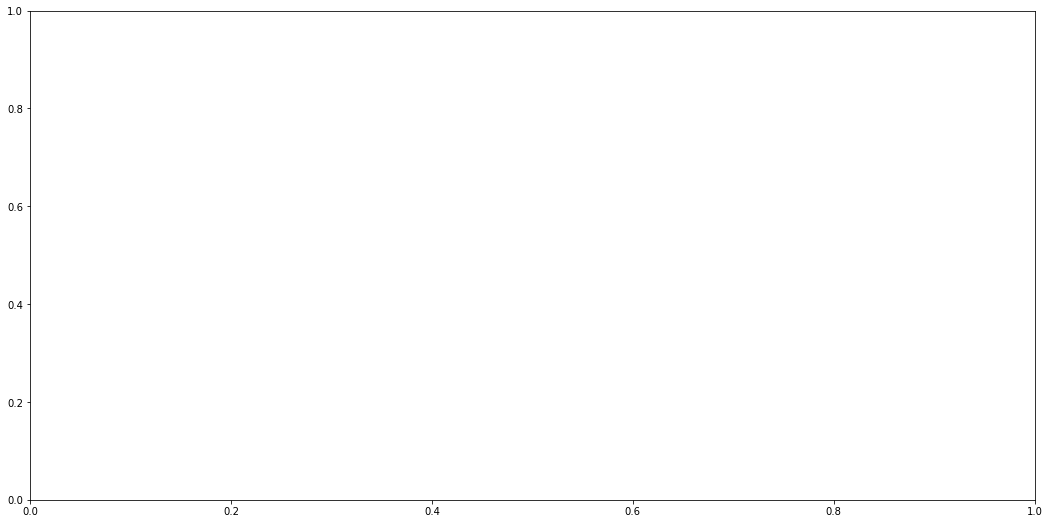

In [18]:
#NO2, O3 , PM10  values over the period of time
air_data['datetime']=pd.to_datetime(air_data.Generated, format='mixed')
air_data['datetime'] = pd.to_datetime(air_data['datetime'])

air_data['NO2 Value'] = pd.to_numeric(air_data['NO2 Value'])
print(air_data['datetime'])
print(air_data['NO2 Value'])
plt.figure(figsize=(18,9))


plt.plot(air_data['datetime'], air_data['NO2 Value'], color='orange', label="NO2 Value")
plt.plot(air_data['datetime'], air_data['O3 Value'], color='blue', label="O3 Value")
plt.plot(air_data['datetime'], air_data['PM10 Value'], color='teal', label='PM10 Value')
plt.title("NO2, O3 , PM10  values over the period of time")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend(loc='best')
plt.show()

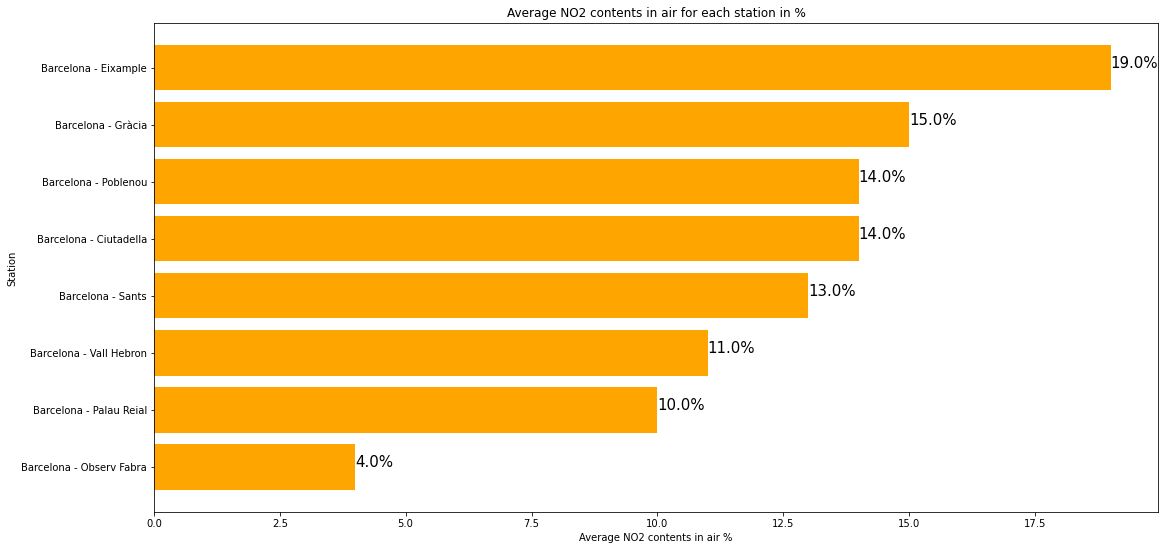

In [19]:
#Average NO2 contents in air for each station
No2_data = (air_data.groupby('Station').agg({'NO2 Value':'mean'}))
No2_per = round((No2_data/No2_data.sum())*100, 0).sort_values('NO2 Value', ascending=True)
plt.figure(figsize=(18,9))
plt.barh(width=No2_per['NO2 Value'], y=No2_per.index, color='orange')
for i, j in zip(No2_per['NO2 Value'], No2_per.index):
    text = plt.annotate(text=str(i)+'%', xytext=(i,j), xy=(i,j))
    text.set_fontsize(15)
plt.title("Average NO2 contents in air for each station in %")
plt.xlabel("Average NO2 contents in air %")
plt.ylabel("Station")
plt.show()

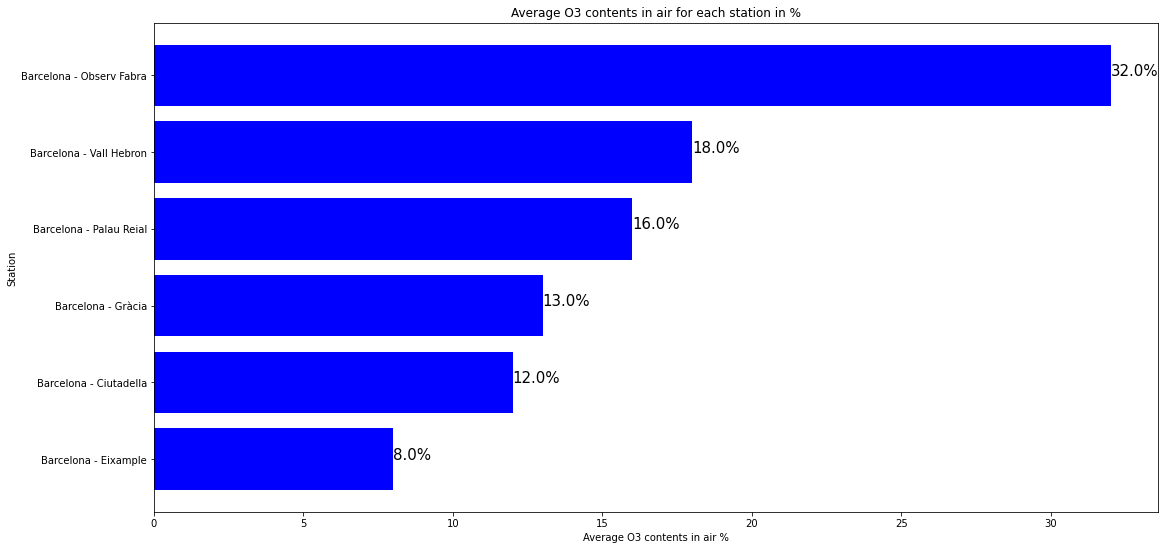

In [20]:
#Average O3 contents in air for each station
O3_data = (air_data.groupby('Station').agg({'O3 Value':'mean'}))
O3_per = round((O3_data/O3_data.sum())*100, 0).sort_values('O3 Value', ascending=True)
plt.figure(figsize=(18,9))
plt.barh(width=O3_per['O3 Value'], y=O3_per.index, color='blue')
for i, j in zip(O3_per['O3 Value'], O3_per.index):
    text = plt.annotate(text=str(i)+'%', xytext=(i,j), xy=(i,j))
    text.set_fontsize(15)
plt.title("Average O3 contents in air for each station in %")
plt.xlabel("Average O3 contents in air %")
plt.ylabel("Station")
plt.show()

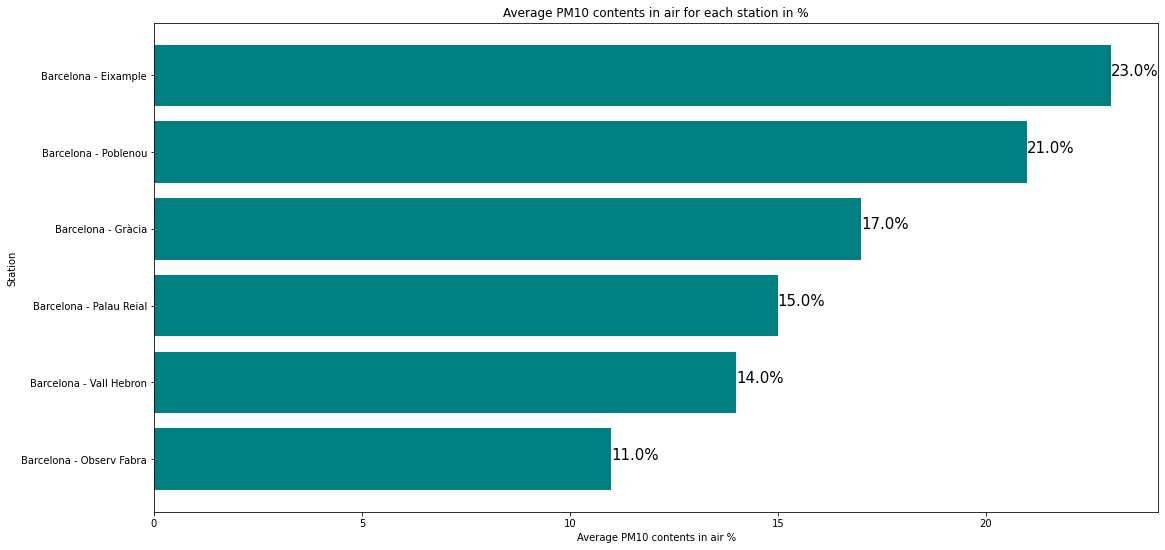

In [21]:
#Average PM10 contents in air for each station
PM10_data = (air_data.groupby('Station').agg({'PM10 Value':'mean'}))
PM10_per = round((PM10_data/PM10_data.sum())*100, 0).sort_values('PM10 Value', ascending=True)
plt.figure(figsize=(18,9))
plt.barh(width=PM10_per['PM10 Value'], y=PM10_per.index, color='teal')
for i, j in zip(PM10_per['PM10 Value'], PM10_per.index):
    text = plt.annotate(text=str(i)+'%', xytext=(i,j), xy=(i,j))
    text.set_fontsize(15)
plt.title("Average PM10 contents in air for each station in %")
plt.xlabel("Average PM10 contents in air %")
plt.ylabel("Station")
plt.show()

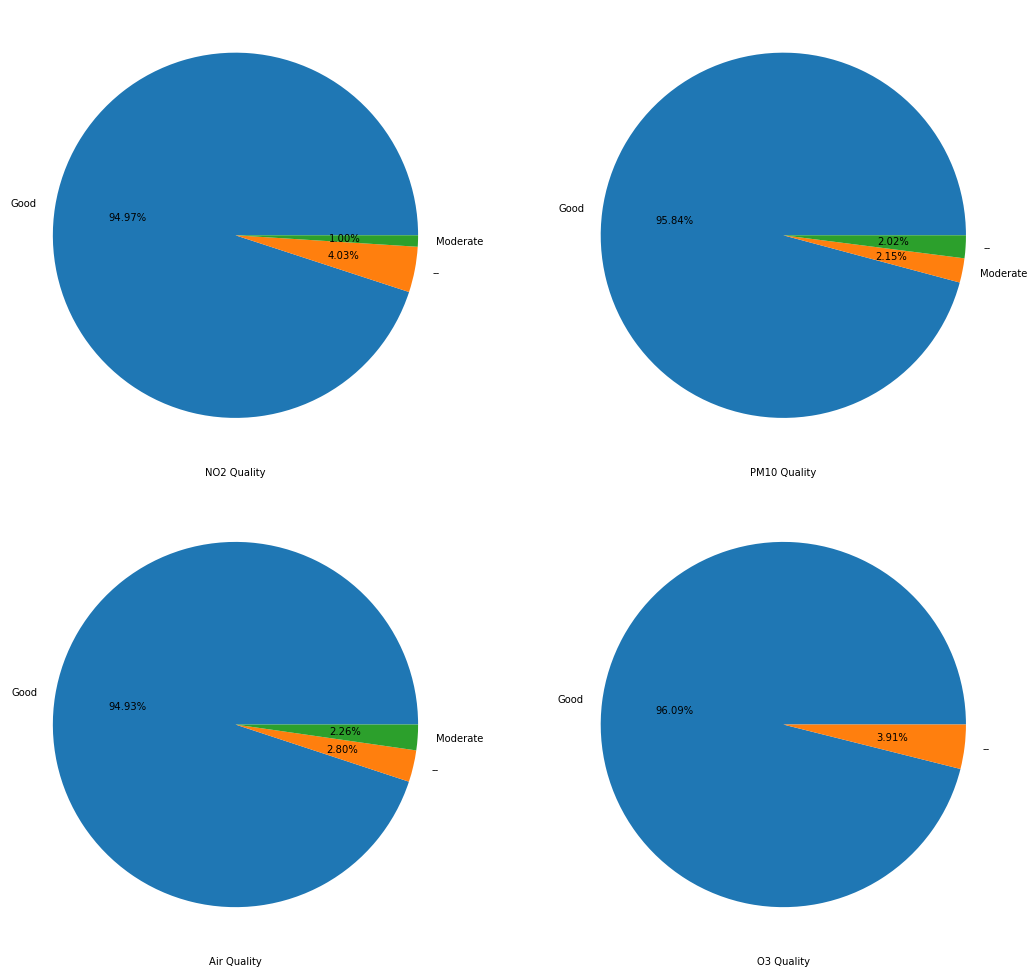

In [22]:
#Quality in %
columns=['Air Quality', 'O3 Quality','NO2 Quality', 'PM10 Quality']
fig = plt.figure(figsize=(18,33))
for i, col in enumerate(columns):
    q, r = divmod(i, 2)
    ax = fig.add_subplot(int(str(q+1)+"2"+str(r+1)))
    ax.pie(air_data[col].value_counts(), labels=air_data[col].value_counts().index, autopct='%.2f%%')
    plt.xlabel(col)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

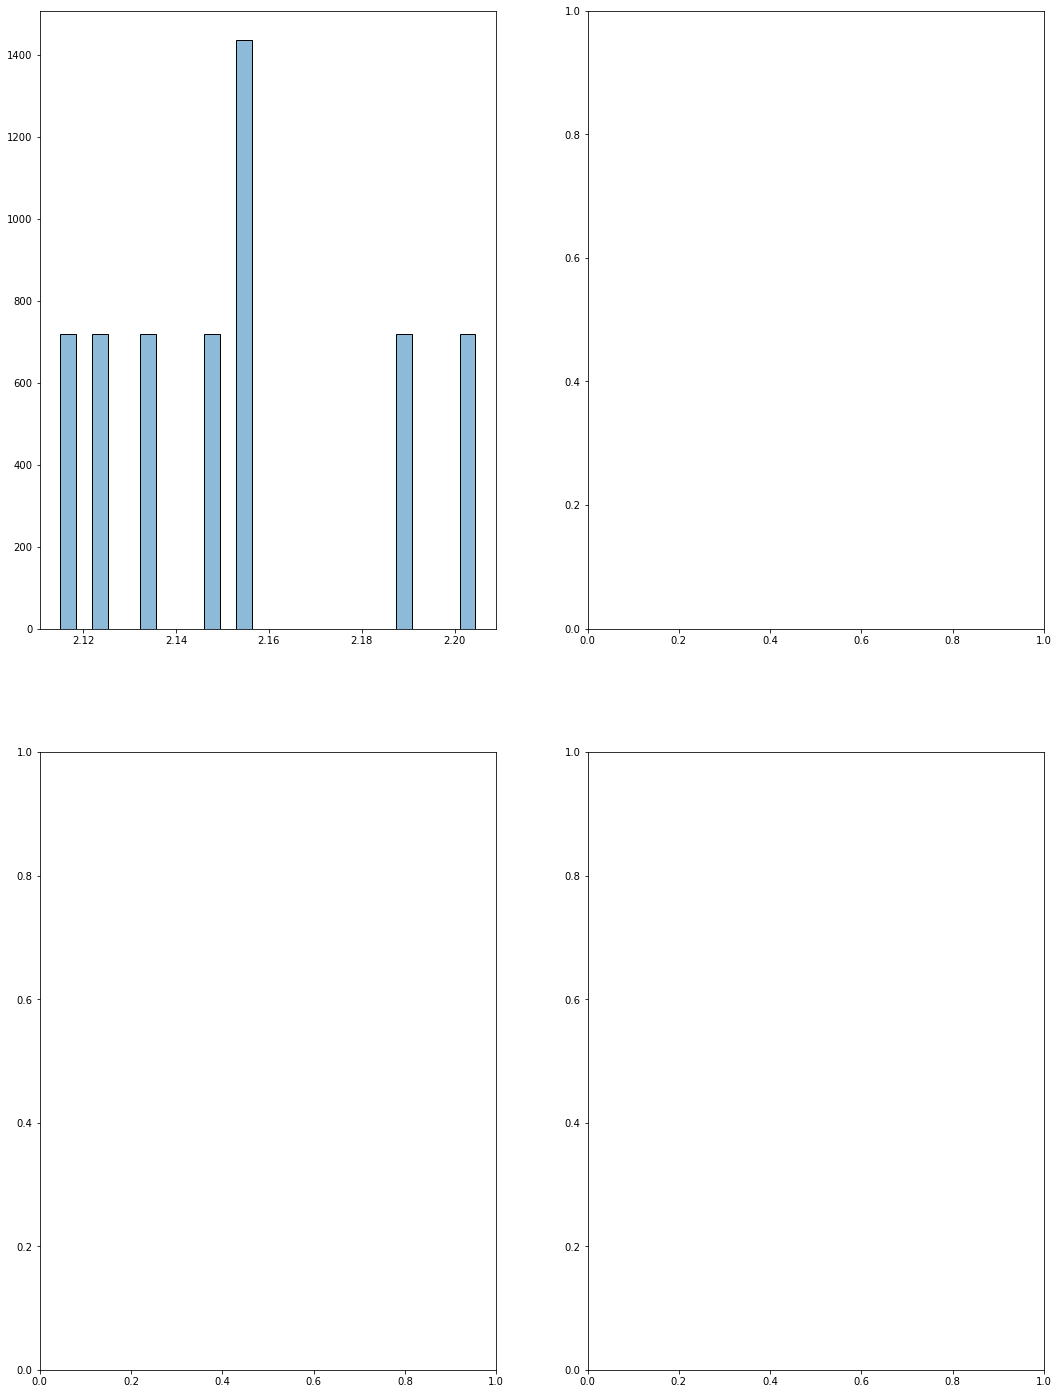

In [25]:
#Distribution of the data
columns=['Longitude', 'O3 Value', 'NO2 Value', 'PM10 Value']
air_data['datetime'] = pd.to_datetime(air_data['datetime'])
air_data['NO2 Value'] = pd.to_numeric(air_data['NO2 Value'])
air_data['Longitude'] = pd.to_numeric(air_data['Longitude'])
q, r = divmod(len(columns), 2)
fig, ax = plt.subplots(q, 2, figsize=(18,25))
for i,col in enumerate(columns):
    q, r = divmod(i,2)
    sbn.histplot(data=air_data, x=col, kde=True, ax=ax[q,r])

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

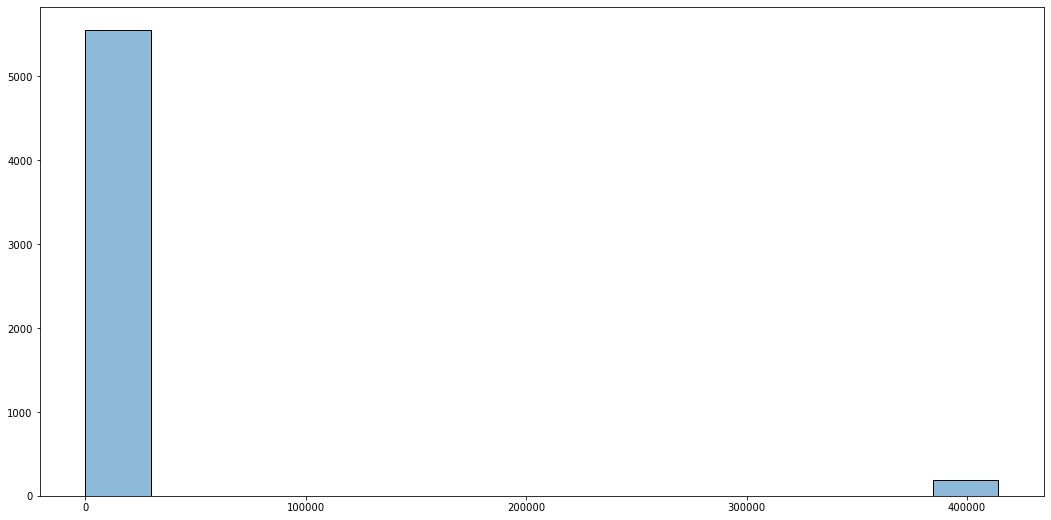

In [26]:
data=air_data.copy(deep=True)
data['Latitude']=data['Latitude'].astype('int')
plt.figure(figsize=(18,9))
sbn.histplot(data=data, x='Latitude', kde=True)
plt.show()

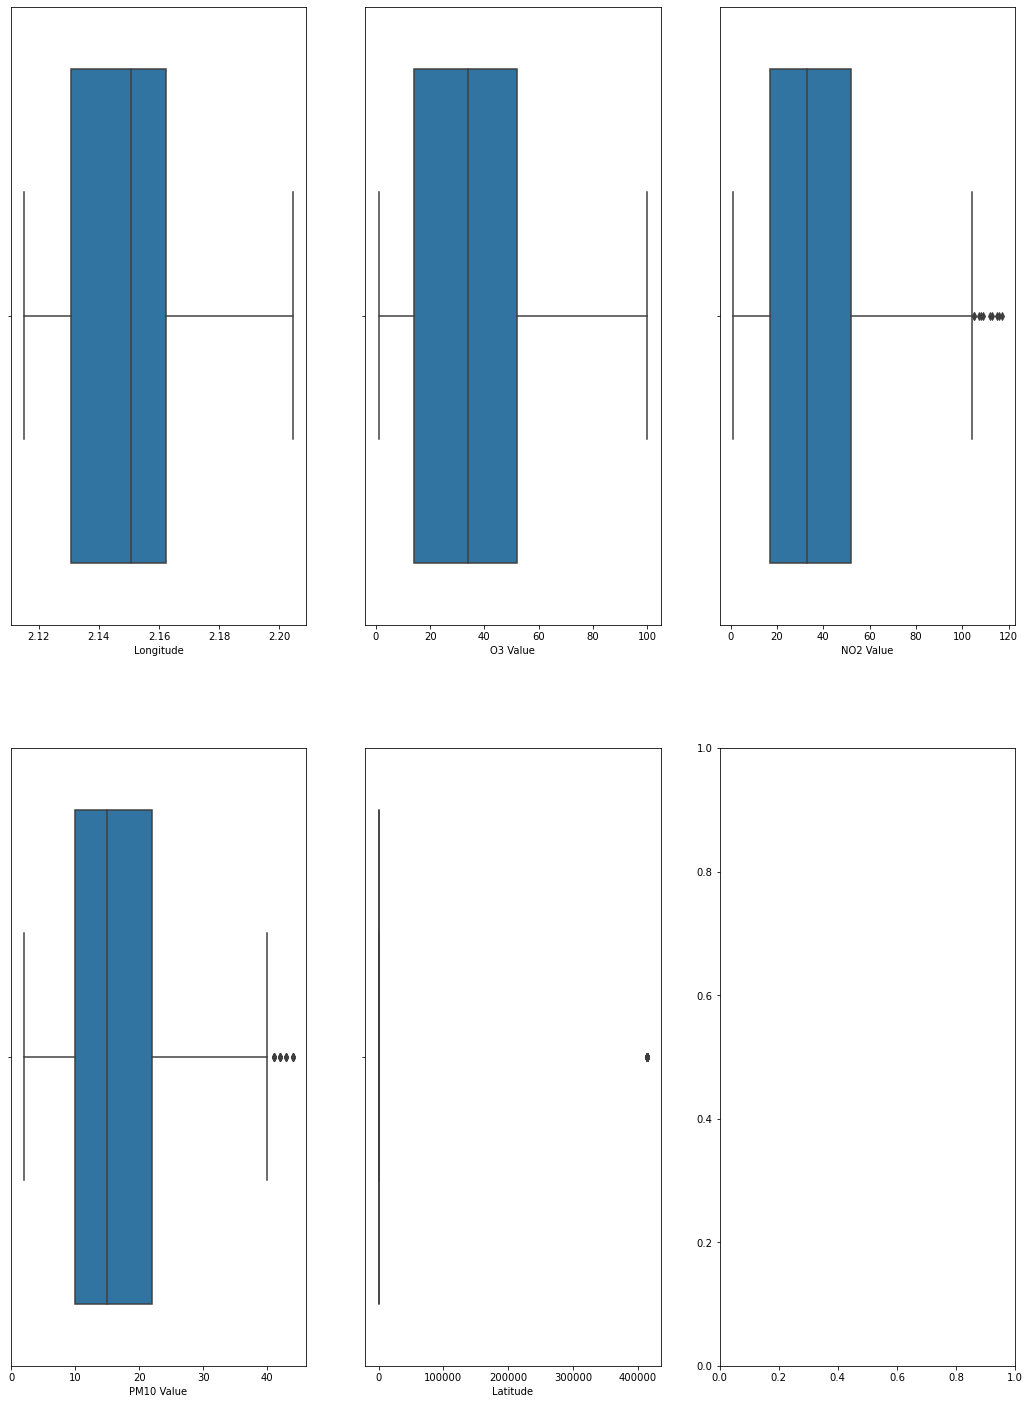

In [27]:
#Distribution of the data
columns=['Longitude', 'O3 Value', 'NO2 Value', 'PM10 Value', 'Latitude']
q, r = divmod(len(columns), 3)
fig, ax = plt.subplots(q+1, 3, figsize=(18,25))
for i,col in enumerate(columns):
    q, r = divmod(i,3)
    sbn.boxplot(data=air_data, x=col, ax=ax[q,r])

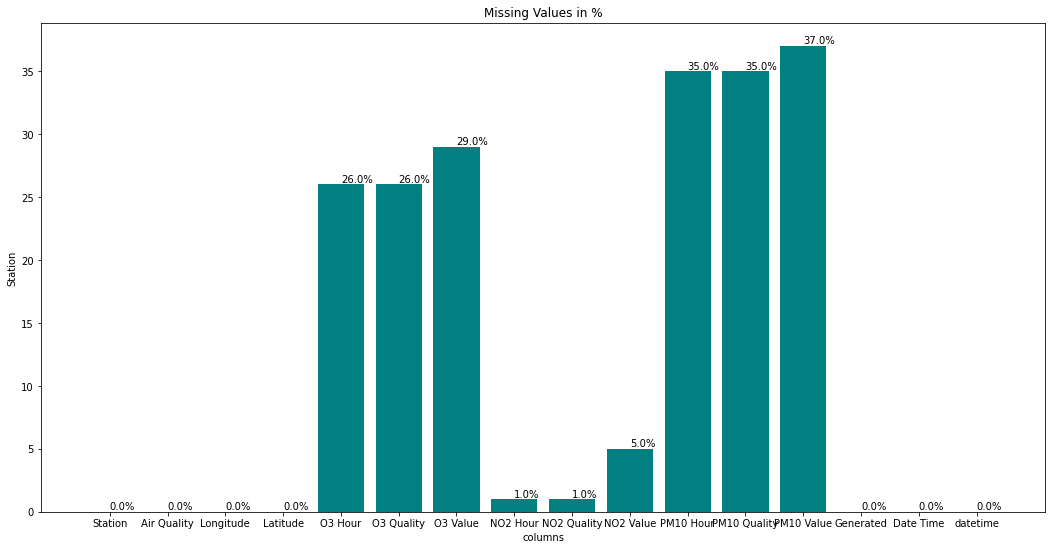

In [28]:
#checking missing values
air_miss = round((air_data.isna().sum()/len(air_data))*100, 0)
plt.figure(figsize=(18,9))
plt.bar(height=air_miss, x=air_miss.index, color='teal')
for i, j in zip(air_miss.index, air_miss):
    text = plt.annotate(text=str(j)+'%', xytext=(i,j), xy=(i,j), va='bottom')
    text.set_fontsize(10)
plt.title("Missing Values in %")
plt.xlabel("columns")
plt.ylabel("Station")
plt.show()

**We need drop O3 Hour, O3 Quality, O3 Value, PM10 Hour, PM10 Quality, PM10 Value**

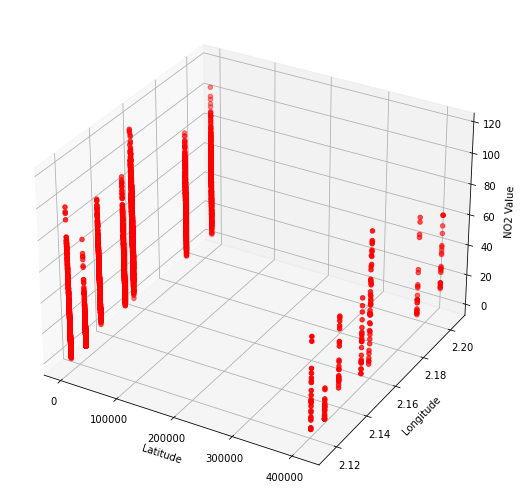

In [29]:
#Relationship between variables
fig = plt.figure(figsize=(18,9))
ax=fig.add_subplot(projection='3d')
ax.scatter(xs=air_data['Latitude'], ys=air_data['Longitude'], zs=air_data['NO2 Value'], color='red')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('NO2 Value')
plt.show()

**2. Data Preparation**

In [30]:
#Feature creation
air_data['Month']=air_data['datetime'].dt.month
air_data['day']=air_data['datetime'].dt.day
air_data['NO2 Hour']=np.where(air_data['NO2 Hour'].isna()==True, 't', air_data['NO2 Hour'])
air_data['NO2 Hour']=[hr.replace('h','') for hr in list(air_data['NO2 Hour'])]
air_data['NO2 Hour']=np.where(air_data['NO2 Hour']=='t', np.NaN, air_data['NO2 Hour'])
air_data['NO2 Hour']=air_data['NO2 Hour'].astype('float')

In [31]:
#Drop unwanted features
columns=['O3 Hour', 'O3 Quality', 'O3 Value', 'PM10 Hour', 'PM10 Quality', 'PM10 Value', 'Generated', 'Date Time', 'datetime']
air_data=air_data.drop(columns, axis=1)
air_data.head()

,Station,Air Quality,Longitude,Latitude,NO2 Hour,NO2 Quality,NO2 Value,Month,day
0,Barcelona - Sants,Good,2.1331,41.3788,0.0,Good,84.0,1,11
1,Barcelona - Eixample,Moderate,2.1538,41.3853,0.0,Moderate,113.0,1,11
2,Barcelona - Gràcia,Good,2.1534,41.3987,0.0,Good,73.0,1,11
3,Barcelona - Ciutadella,Good,2.1874,41.3864,0.0,Good,86.0,1,11
4,Barcelona - Vall Hebron,Good,2.1480,41.4261,0.0,Good,69.0,1,11


In [32]:
air_data.to_csv('data/new_air_data.csv')

In [33]:
#Handling Missing Values
le = LabelEncoder()
air_data['Air Quality']=le.fit_transform(air_data['Air Quality'])
air_data['NO2 Quality']=air_data['NO2 Quality'].map({'Good':1, 'Moderate':2, '--':0})
air_data['Station']=air_data['Station'].map({'Barcelona - Sants':0, 'Barcelona - Eixample':1, 'Barcelona - Gràcia':2, 'Barcelona - Ciutadella':3, 'Barcelona - Vall Hebron':4, 'Barcelona - Palau Reial':5, 'Barcelona - Poblenou':6, 'Barcelona - Observ Fabra':7})

In [34]:
knn=KNNImputer(n_neighbors=5)
air_impute = pd.DataFrame(knn.fit_transform(air_data.drop(['Air Quality'], axis=1)))
air_impute['Air Quality']=air_data['Air Quality']
air_impute.columns=['Station','Longitude','Latitude', 'NO2 Hour', 'NO2 Quality', 'NO2 Value', 'Month', 'day', 'Air Quality']

In [36]:
air_data.head()

,Station,Air Quality,Longitude,Latitude,NO2 Hour,NO2 Quality,NO2 Value,Month,day
0,0,1,2.1331,41.3788,0.0,1.0,84.0,1,11
1,1,2,2.1538,41.3853,0.0,2.0,113.0,1,11
2,2,1,2.1534,41.3987,0.0,1.0,73.0,1,11
3,3,1,2.1874,41.3864,0.0,1.0,86.0,1,11
4,4,1,2.1480,41.4261,0.0,1.0,69.0,1,11


In [37]:
#One hot encoding
air_impute=pd.get_dummies(air_impute, columns=['Station'])

In [38]:
air_impute.head()

,Longitude,Latitude,NO2 Hour,NO2 Quality,NO2 Value,Month,day,Air Quality,Station_0.0,Station_1.0,Station_2.0,Station_3.0,Station_4.0,Station_5.0,Station_6.0,Station_7.0
0,2.1331,41.3788,0.0,1.0,84.0,1.0,11.0,1,True,False,False,False,False,False,False,False
1,2.1538,41.3853,0.0,2.0,113.0,1.0,11.0,2,False,True,False,False,False,False,False,False
2,2.1534,41.3987,0.0,1.0,73.0,1.0,11.0,1,False,False,True,False,False,False,False,False
3,2.1874,41.3864,0.0,1.0,86.0,1.0,11.0,1,False,False,False,True,False,False,False,False
4,2.1480,41.4261,0.0,1.0,69.0,1.0,11.0,1,False,False,False,False,True,False,False,False


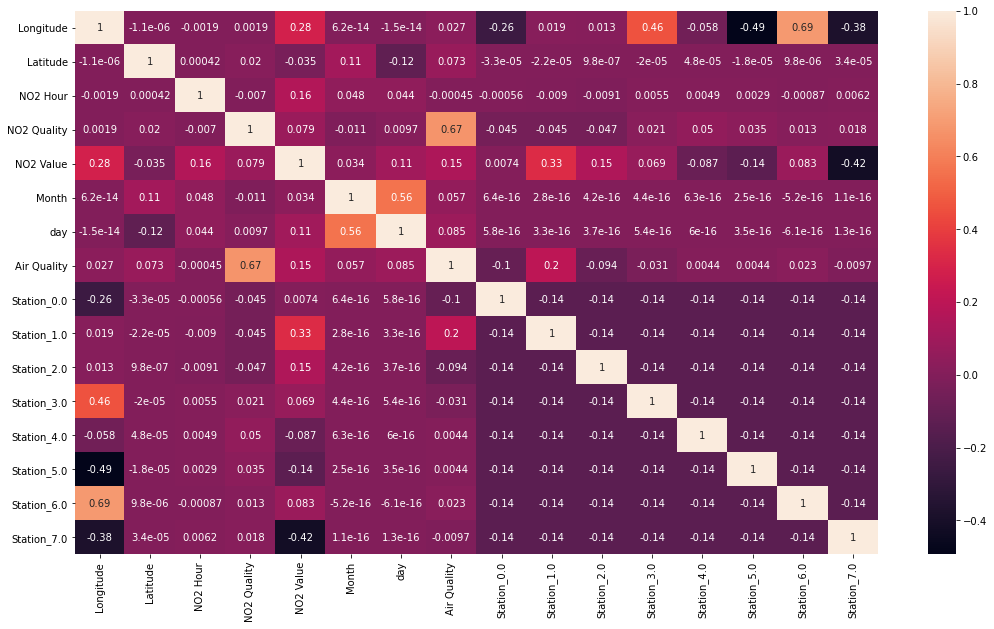

In [39]:
#Correlation Analysis
plt.figure(figsize=(18,10))
sbn.heatmap(air_impute.corr(), annot=True)
plt.show()

In [40]:
features=air_impute.drop(['Air Quality'], axis=1)
target=air_impute['Air Quality']

Selected Features
 Index(['Longitude', 'Latitude', 'NO2 Hour', 'NO2 Quality', 'NO2 Value',
       'Month', 'day', 'Station_0.0', 'Station_1.0', 'Station_2.0'],
      dtype='object')


ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

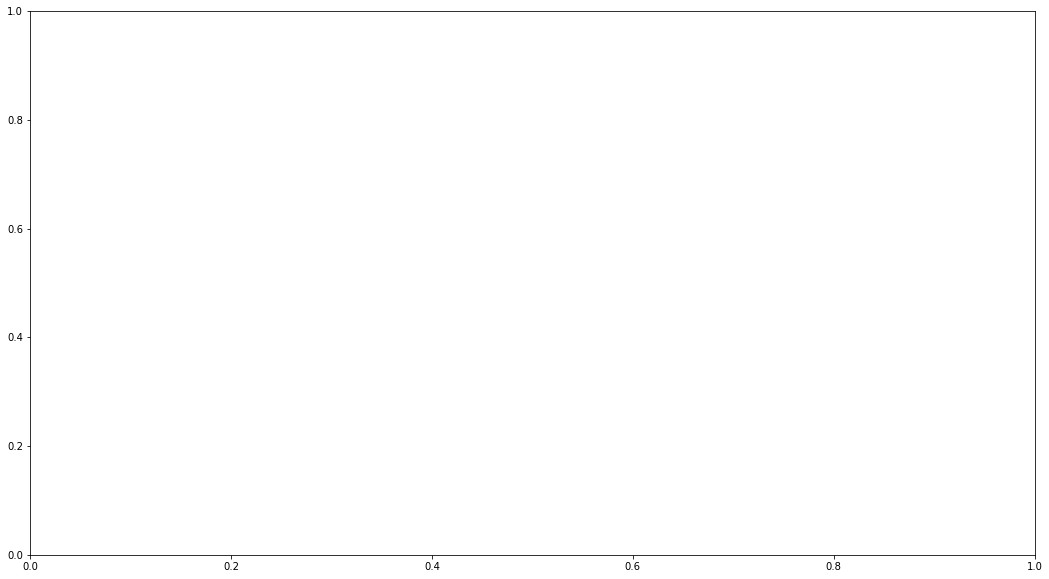

In [42]:
#Feature Selection
kfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
warnings.filterwarnings('ignore')
rf = RFECV(RandomForestClassifier(n_jobs=-1),cv=kfold, scoring='accuracy')
rf=rf.fit(features,target)
print("Selected Features\n", features.columns[rf.support_])
plt.figure(figsize=(18,10))
plt.plot(range(1, len(rf.grid_scores_)+1), np.mean(rf.grid_scores_))
plt.xlabel("No. of Features")
plt.ylabel("Accuracy")
plt.title("No. of Features vs Accuracy")
plt.show()

**3. Model Building**

In [ ]:
#Train Test Split
features=features.loc[:, features.columns[rf.support_]]
x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=.20, random_state=10)

In [ ]:
#Train the model
rf = RandomForestClassifier(n_jobs=-1).fit(x_train, y_train)

In [ ]:
#Predictions
train_pred = rf.predict(x_train)
test_pred = rf.predict(x_test)

**4. Model Evaluation**

In [ ]:
#Accuracy
print("Training Accuracy", accuracy_score(y_train, train_pred))
print("Testing Accuracy", accuracy_score(y_test, test_pred))

In [ ]:
#Classification report for test data
print(classification_report(y_test, test_pred))

In [ ]:
#confusion matrix for test data
print(confusion_matrix(y_test, test_pred))

**5. Cross Validation Score**

In [ ]:
kfold=StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
np.mean(cross_val_score(RandomForestClassifier(n_jobs=-1),features,target,cv=kfold, scoring='accuracy'))